In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

In [2]:
# Pandas
pd.set_option('display.max_rows', 100)

# Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'font.size': 18})


Generate Dataset

In [176]:
n_rows = 180

raw_data = pd.DataFrame({"Categories": ["".join(np.random.choice(list("AB"), size=2)) for _ in range(n_rows)]}
                        ,index=pd.date_range(start='1/1/2018', periods=n_rows, freq='D'))

data = raw_data["Categories"].groupby(pd.Grouper(freq="M")).value_counts().to_frame("Volume")
data["Probability"] = raw_data["Categories"].groupby(pd.Grouper(freq="M")).value_counts(normalize=True)
data.reset_index(inplace=True)
data.rename(columns={'level_0': "Dates"}, inplace=True)
data["Dates"] = data["Dates"].dt.date

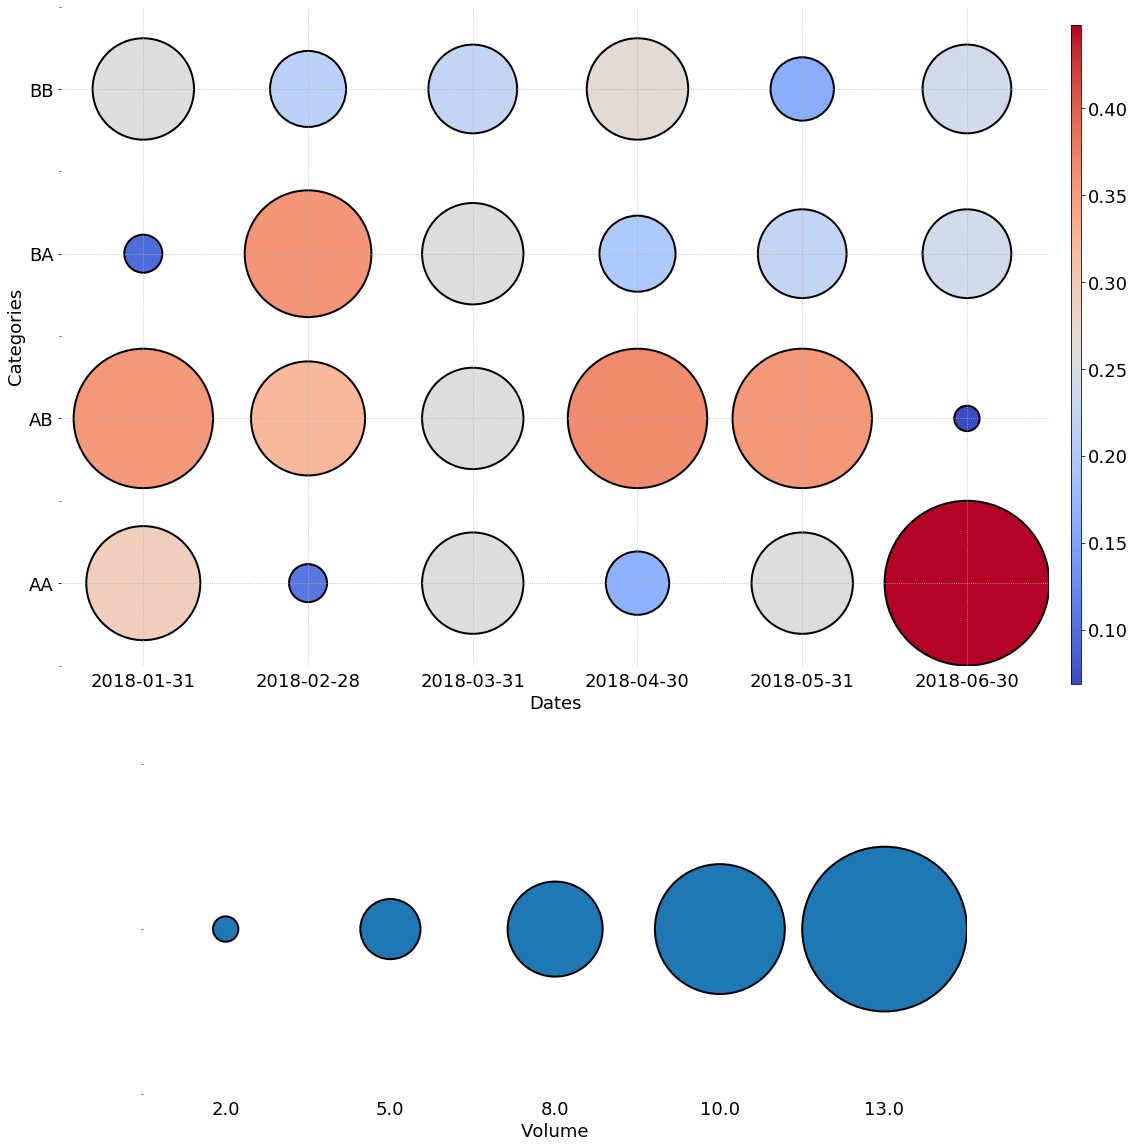

In [189]:
#srcs: https://blogs.oii.ox.ac.uk/bright/2014/08/12/point-size-legends-in-matplotlib-and-basemap-plots/




# Setup Grid and Values

volume = data.pivot(index="Categories", columns="Dates", values="Volume") #np.random.randint(0, 180, size=(data.shape[0], data.shape[1]))
probabilities = data.pivot(index="Categories", columns="Dates", values="Probability").values

# Get Labels
ylabels = volume.index
xlabels = volume.columns.values
x, y = np.meshgrid(np.arange(xlabels.shape[0]), np.arange(ylabels.shape[0]))

volume = volume.values

# Start figure setup
fig, (heatmap, legend) = plt.subplots(figsize=(20,20), nrows=2, gridspec_kw={'height_ratios': [2, 1]})
radii_list = volume/volume.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radii_list.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=probabilities.flatten(), cmap='coolwarm', edgecolors='k', linewidth=2)
heatmap.add_collection(col)

heatmap.set(xticks=np.arange(xlabels.shape[0]), yticks=np.arange(ylabels.shape[0])
           ,xticklabels=xlabels, yticklabels=ylabels)

heatmap.set_xticks(np.arange(xlabels.shape[0]+1)-0.5, minor=True)
heatmap.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, minor=True)
heatmap.grid(which='major', linestyle=":")
heatmap.set_ylabel("Categories")
heatmap.set_xlabel("Dates")

heatmap.axes.set_aspect('equal')

# Legend

legend_points = 5

leg_xticklabels = [round(x) for x in np.linspace(volume.min(), volume.max(), legend_points)]
leg_yticklabels = [0, 1]

legend_circles = [plt.Circle((i, 0.5), radius=r) for r, i in zip(np.linspace(min(radii_list.flat), max(radii_list.flat), legend_points), range(legend_points))]
legend_col = PatchCollection(legend_circles, edgecolors='k', linewidth=2)
legend.add_collection(legend_col)

leg_xticks = np.arange(legend_points)


legend.set(xticks=leg_xticks, yticks=[]
           ,xticklabels=leg_xticklabels, yticklabels=leg_yticklabels)
legend.set_xticks(np.arange(len(leg_xticklabels)+1)-0.5, minor=True)
legend.set_yticks(np.arange(len(leg_yticklabels)+1)-0.5, minor=True)

legend.set_xlabel("Volume")
legend.axes.set_aspect('equal')
# fig.colorbar(col)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(heatmap,
                   width="1%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='upper right',
                   bbox_to_anchor=(0.05, 0., 1, 1),
                   bbox_transform=heatmap.transAxes,
                   borderpad=1,
                   )
fig.colorbar(col, cax=axins)

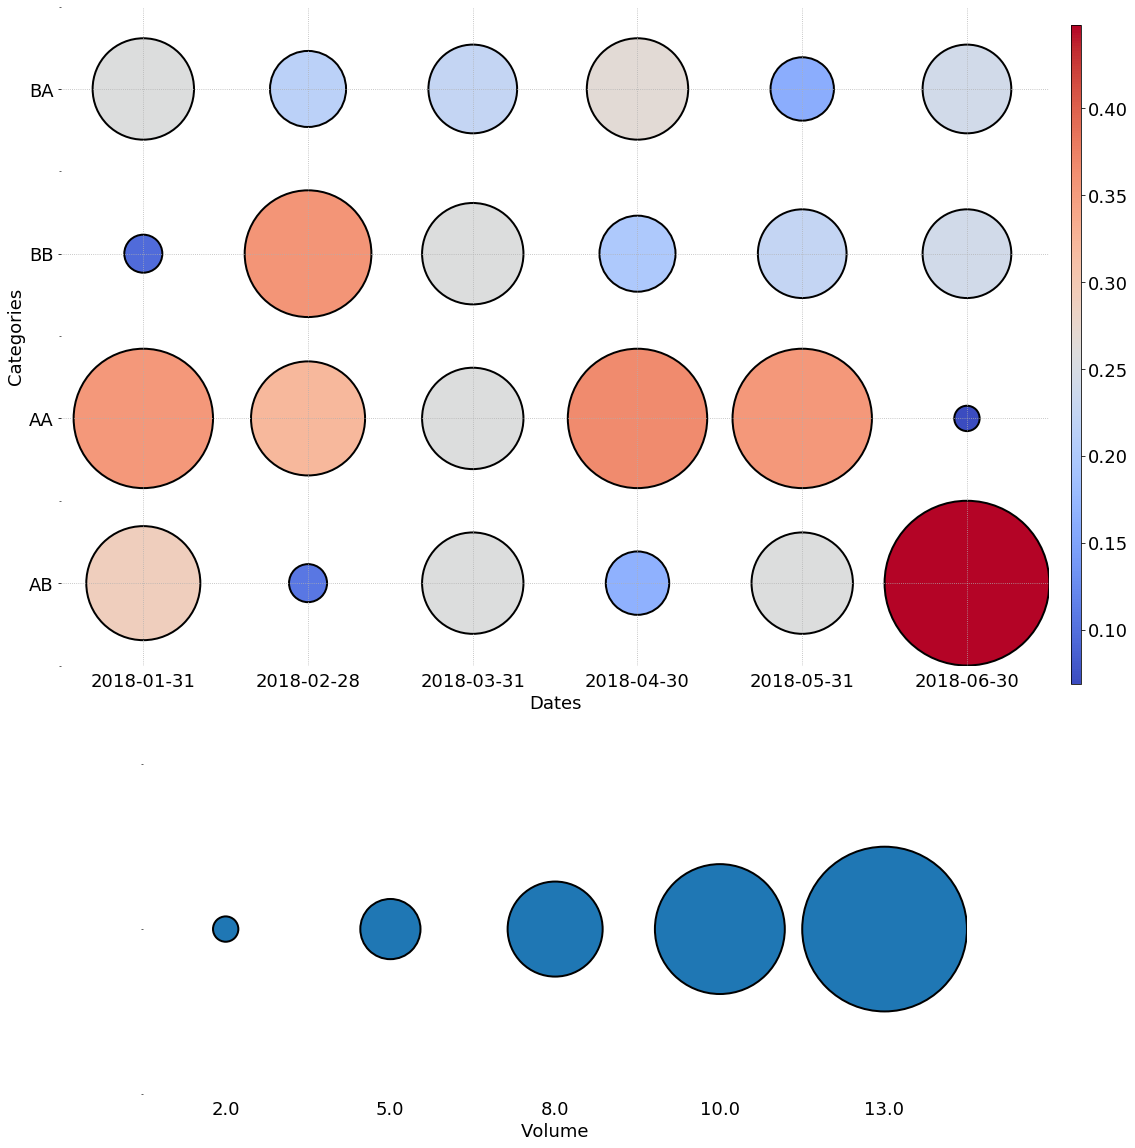

In [200]:
#srcs: https://blogs.oii.ox.ac.uk/bright/2014/08/12/point-size-legends-in-matplotlib-and-basemap-plots/


def heatmap_4d(x, y, data):

    # Setup Grid and Values

    volume = data.pivot(index=y, columns=x, values="Volume").values
    probabilities = data.pivot(index=y, columns=x, values="Probability").values

    # Get Labels
    ylabels = data[y].drop_duplicates().values
    xlabels = data[x].drop_duplicates().values
    x, y = np.meshgrid(np.arange(xlabels.shape[0]), np.arange(ylabels.shape[0]))

    # Start figure setup
    fig, (heatmap, legend) = plt.subplots(figsize=(20,20), nrows=2, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot Heatmap
    radii_list = volume/volume.max()/2
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radii_list.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=probabilities.flatten(), cmap='coolwarm', edgecolors='k', linewidth=2)
    heatmap.add_collection(col)

    heatmap.set(xticks=np.arange(xlabels.shape[0]), yticks=np.arange(ylabels.shape[0])
               ,xticklabels=xlabels, yticklabels=ylabels)

    heatmap.set_xticks(np.arange(xlabels.shape[0]+1)-0.5, minor=True)
    heatmap.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, minor=True)
    heatmap.grid(which='major', linestyle=":")
    heatmap.set_ylabel("Categories")
    heatmap.set_xlabel("Dates")

    heatmap.axes.set_aspect('equal')

    # Legend

    legend_points = 5

    leg_xticklabels = [round(x) for x in np.linspace(volume.min(), volume.max(), legend_points)]
    leg_yticklabels = [0, 1]

    legend_circles = [plt.Circle((i, 0.5), radius=r) for r, i in zip(np.linspace(min(radii_list.flat), max(radii_list.flat), legend_points), range(legend_points))]
    legend_col = PatchCollection(legend_circles, edgecolors='k', linewidth=2)
    legend.add_collection(legend_col)

    leg_xticks = np.arange(legend_points)


    legend.set(xticks=leg_xticks, yticks=[]
               ,xticklabels=leg_xticklabels, yticklabels=leg_yticklabels)
    legend.set_xticks(np.arange(len(leg_xticklabels)+1)-0.5, minor=True)
    legend.set_yticks(np.arange(len(leg_yticklabels)+1)-0.5, minor=True)

    legend.set_xlabel("Volume")
    legend.axes.set_aspect('equal')

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    axins = inset_axes(heatmap,
                       width="1%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='upper right',
                       bbox_to_anchor=(0.05, 0., 1, 1),
                       bbox_transform=heatmap.transAxes,
                       borderpad=1,
                       )
    fig.colorbar(col, cax=axins)
    
    return heatmap, legend

heatmap, legend = heatmap_4d("Dates", "Categories", data)

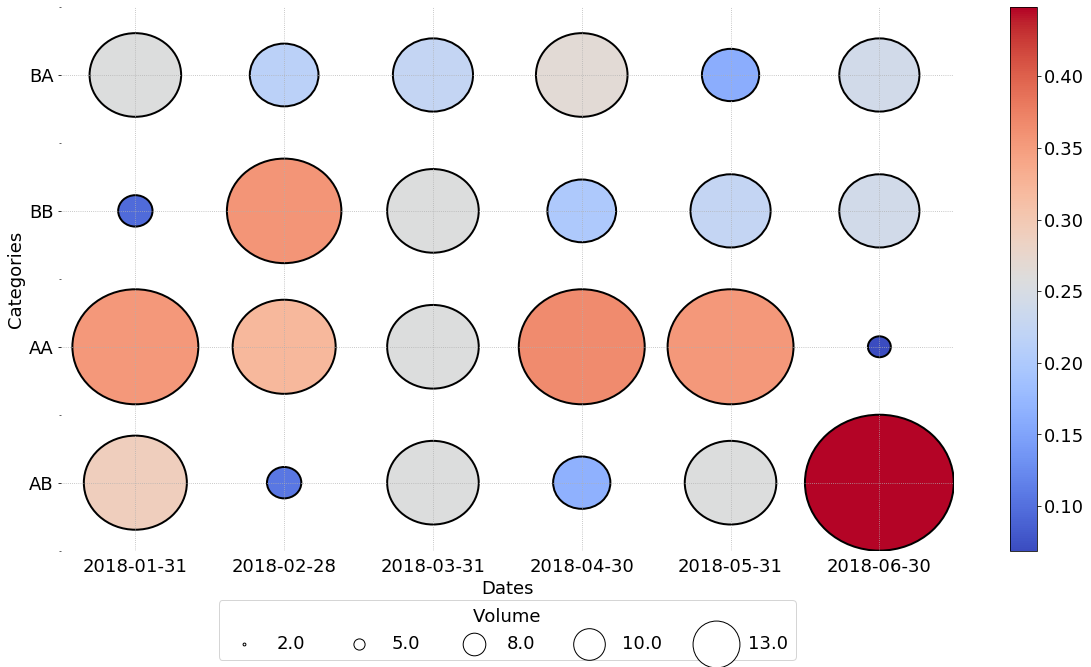

In [178]:

#srcs: https://blogs.oii.ox.ac.uk/bright/2014/08/12/point-size-legends-in-matplotlib-and-basemap-plots/

legend_points = 5

# Get Labels
ylabels = data["Categories"].drop_duplicates()
xlabels = data["Dates"].drop_duplicates()

# Setup Grid and Values
x, y = np.meshgrid(np.arange(xlabels.shape[0]), np.arange(ylabels.shape[0]))
volume = data.pivot(index="Categories", columns="Dates", values="Volume").values #np.random.randint(0, 180, size=(data.shape[0], data.shape[1]))
probabilities = data.pivot(index="Categories", columns="Dates", values="Probability").values

# Start figure setup
fig, heatmap = plt.subplots()
radii_list = volume/volume.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radii_list.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=probabilities.flatten(), cmap='coolwarm', edgecolors='k', linewidth=2)
heatmap.add_collection(col)

heatmap.set(xticks=np.arange(xlabels.shape[0]), yticks=np.arange(ylabels.shape[0])
           ,xticklabels=xlabels, yticklabels=ylabels)

heatmap.set_xticks(np.arange(xlabels.shape[0]+1)-0.5, minor=True)
heatmap.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, minor=True)
heatmap.grid(which='major', linestyle=":")
heatmap.set_ylabel("Categories")
heatmap.set_xlabel("Dates")

handles_labels_map = {label: ax.scatter([], [], s=label**3, edgecolors='black', color="white") 
                      for label in [round(x) for x in np.linspace(volume.min(), volume.max(), legend_points)]}

handles =  list(handles_labels_map.values())
labels = list(handles_labels_map.keys())
plt.legend(handles, labels, title='Volume', scatterpoints=1, ncol=legend_points
          ,loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True)

fig.colorbar(col)

AttributeError: 'PathCollection' object has no attribute 'set_yticks'

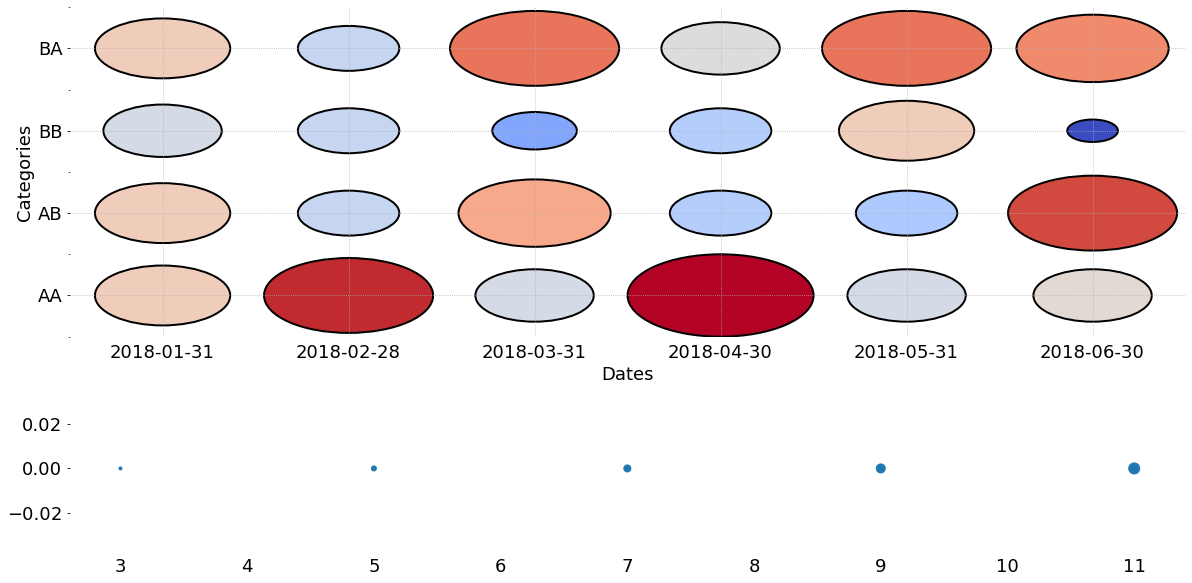

In [113]:
#srcs: https://blogs.oii.ox.ac.uk/bright/2014/08/12/point-size-legends-in-matplotlib-and-basemap-plots/

# Get Labels
ylabels = data["Categories"].drop_duplicates()
xlabels = data["Dates"].drop_duplicates()

# Setup Grid and Values
x, y = np.meshgrid(np.arange(xlabels.shape[0]), np.arange(ylabels.shape[0]))
volume = data.pivot(index="Categories", columns="Dates", values="Volume").values #np.random.randint(0, 180, size=(data.shape[0], data.shape[1]))
probabilities = data.pivot(index="Categories", columns="Dates", values="Probability").values

# Start figure setup
fig, (heatmap, legend) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [2, 1]})
radii_list = volume/volume.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radii_list.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=probabilities.flatten(), cmap='coolwarm', edgecolors='k', linewidth=2)
heatmap.add_collection(col)

heatmap.set(xticks=np.arange(xlabels.shape[0]), yticks=np.arange(ylabels.shape[0])
           ,xticklabels=xlabels, yticklabels=ylabels)

heatmap.set_xticks(np.arange(xlabels.shape[0]+1)-0.5, minor=True)
heatmap.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, minor=True)
heatmap.grid(which='major', linestyle=":")
heatmap.set_ylabel("Categories")
heatmap.set_xlabel("Dates")

# Legend

legend_points = 5

leg_xticklabels = [round(x) for x in np.linspace(volume.min(), volume.max(), legend_points)]
leg_yticklabels = [0]

legend = legend.scatter(leg_xticklabels, leg_yticklabels*len(leg_xticklabels), s=np.linspace(volume.min(), volume.max(), legend_points)**2)
legend.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, leg_yticklabels, minor=True)
# legend.set_ylabel("Volume")

fig.colorbar(col)

In [ ]:
radius_point = 